In [1]:
# This code is for doing feature extraction for cz4042 final project
# Speech emotion recognition

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
# Labels for emotions
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
# Data path to load input audio dataset
DATA_PATH = './inputs/Audio_Speech_Actors_01-24/'
SAMPLE_RATE = 44100

In [3]:
# Create a new dataframe and load all audio input files inside, with four columns,'Emotion', 'Intensity', 'Gender','Path'

data = pd.DataFrame(columns=['Emotion', 'Intensity', 'Gender','Path'])

for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8:
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Intensity,Gender,Path
0,5,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1,6,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2,6,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3,5,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4,7,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...


Mel-spectrogram shape:  (60, 513)


/Users/yzhang/.pyenv/versions/3.7.1/envs/cz4042_final/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/yzhang/.pyenv/versions/3.7.1/envs/cz4042_final/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


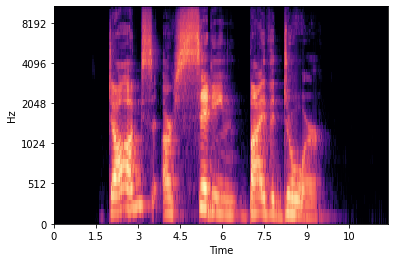

In [4]:
# Method to calculate Mel-spectrogram using librosa library
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 258,
                                              n_mels=60,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Test function for feature extraction
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('Mel-spectrogram shape: ',mel_spectrogram.shape)

In [5]:
# Generate mel-spectrogram data for all raw inputs files 
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=2.5, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(data)),end='')

 Processed 1439/1440 files

In [6]:
print('Mel-spectrogram shape: ',mel_spectrogram.shape)

Mel-spectrogram shape:  (60, 513)


In [7]:
# Function used for data augmentation
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [8]:
# Data augmentation
for i,signal in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 1439/1440 files

In [9]:
print('Mel-spectrogram shape: ',mel_spectrogram.shape)

Mel-spectrogram shape:  (60, 513)


In [10]:
data.head()

,Emotion,Intensity,Gender,Path
0,5,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
1,6,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
2,6,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
3,5,strong,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...
4,7,normal,female,./inputs/Audio_Speech_Actors_01-24/Actor_16/03...


In [11]:
print(len(data))

4320


In [12]:
# Save data pickle file for further use
data.to_pickle("./inputs/data_df_1.pkl")

In [13]:
# Method to split data into chunks
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [20]:
# Get chunks of Mel-spectrogram data
mel_spectrograms_chunked = []
for mel_spec in mel_spectrograms:
    chunks = splitIntoChunks(mel_spec, win_size=216,stride=160)
    mel_spectrograms_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

Number of chunks is 2


In [21]:
mel_spectrograms_chunked = np.array(mel_spectrograms_chunked)

In [22]:
print('Mel-spectrogram-chunked shape: ',mel_spectrograms_chunked.shape)

Mel-spectrogram-chunked shape:  (4320, 2, 60, 216)


In [24]:
# Change type frome list to np list for reshape
arr = np.array(mel_spectrograms_chunked)
# print(arr.shape)
# print(len(arr))
# print(type(arr))
# print(arr[0])

(4320, 2, 60, 216)
4320
<class 'numpy.ndarray'>
[[[-80.         -80.         -80.         ... -65.58497956 -71.75707657
   -62.84482522]
  [-80.         -80.         -80.         ... -54.48661897 -57.59401736
   -61.59374893]
  [-80.         -80.         -80.         ... -51.3214946  -53.26740061
   -54.34935051]
  ...
  [-80.         -80.         -80.         ... -35.27971085 -36.03943439
   -39.31599331]
  [-80.         -80.         -80.         ... -39.22731017 -36.48513243
   -39.20577163]
  [-80.         -80.         -80.         ... -44.94307591 -45.19873847
   -47.6746179 ]]

 [[-65.86260842 -67.31428646 -65.28444748 ... -36.18594697 -38.0991426
   -35.09603016]
  [-56.97623194 -57.10194513 -62.09413082 ... -23.6494847  -24.12405467
   -22.22708553]
  [-56.04633004 -54.27408033 -52.1952475  ... -20.47817364 -21.52210122
   -18.02221002]
  ...
  [-80.         -80.         -80.         ... -68.59825772 -66.64235733
   -63.2935983 ]
  [-80.         -80.         -80.         ... -66

In [27]:
# Reshape mel-spectrogram data inorder to save for further use
reshape = arr.reshape(4320, 2*60*216)
# print(len(reshape))
# print(reshape[0])

4320
[-80.         -80.         -80.         ... -72.21595615 -72.75324638
 -72.99821306]


In [28]:
# Save data after feature extraction into npy file for further use
np.save("./inputs/mel_spec_data_1.npy", reshape)